In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
%matplotlib inline
sns.set_style("ticks")

# 5. Text Mining

In this Jupyter notebook, we will go through a typical text miningpipeline. Our goal is to train a machine learning model that classifies texts scraped from company website into two classes: 
- ```0```: Text from a non-software company website.
- ```1```: Text from a software company website.

To do so, we will do the following:
1. Load a labelled and an unlabelled dataset.
2. Preprocess the texts.
3. Vectorize the texts.
4. Split the labelled dataset into a training set and a test set.
5. Train a logit regression classifier.
6. Use the trained logit regression classifier to predict the missing labels in the unlabelled dataset.
7. Calculate text similarities.

## 5.1 Load data

We will work with two different datasets: a labelled dataset and an unlabelled one. For the observations in the labelled dataset, we know whether the texts are from a software company website ("class_1" in the figure) or not ("class_2"). For the observations in the unlabelled dataset, we do not have this information and we want to **predict the missing classes**.

<img src="../misc/labelled_data.png" width="400">

### Load labelled data

First we load "labelled_data.txt", a text file with "labelled" website data. "Labelled" means that each observation is already categorized into a group.

Our data is in a table format with 4 columns:
- **"ID"**: unique identifiers for each observation
- **"url"**: the website address from where text was downloaded
- **"text"**: the downloaded website text
- **"software"**: the label which tells us whether a website is from a software company ("1") or not ("0")

In [5]:
labelled_data = pd.read_csv("../data/labelled_data.txt", sep="\t", encoding="utf-8", error_bad_lines=False)
labelled_data.head(5)

,ID,url,text,software
0,0,http://autzen-reimers.de,Seite: « 1 / 0 » « 1 / 0 »AUTZEN & REIMERSARCH...,0
1,1,https://ibos-goerlitz.de/,Das Ingenieurbüro IBOS GmbH wurde am 17.09.199...,0
2,2,https://kaizhong-vogt.de/,capanne.gittinger.de,0
3,3,https://baecker-holland.de/,Klicken Sie hier um zu unserem Kon­takt­for­mu...,0
4,4,https://www.vbhnr.de/privatkunden.html,Um Ihnen eine bessere Nutzung unserer Seite zu...,0


We have 2000 rows (observations) and 4 columns.

In [6]:
labelled_data.shape

(2000, 4)

Let's have a look at the website of a random software company in our dataset.

In [10]:
from IPython.display import IFrame

random_software_url = labelled_data[labelled_data["software"] == 1].sample(1)["url"].values[0]

display(IFrame(random_software_url, width=800, height=400))

Let's first have a look at the "software" column and check out how many ```1``` (software companies) and ```0``` (other company types) we have in our data. 

For that we select the "software" column and then use pandas ```value_counts()``` method to count the ones and zeros in that column. As we can see, 1716 ```0``` and 284 ```1``` are in the dataset, which means that we have many more non-software firms than software firms in our labelled dataset.

In [5]:
labelled_data["software"].value_counts()

0    1716
1     284
Name: software, dtype: int64

Let's have a closer look at our text data.

First, we may want to see how large our texts are. We can do so by selecting the "text" column and use ```apply(len)``` on it. This will return us the lenght (number of characters) of each text in our dataset. By adding pandas ```describe()``` method, we will get some descriptive statistics telling us that the mean number number of characters (2558.8) per website text, for example.

In [11]:
labelled_data["text"].apply(len).describe()

count      2000.000000
mean       2558.813500
std        5144.796468
min           1.000000
25%         703.000000
50%        1472.500000
75%        2788.500000
max      135504.000000
Name: text, dtype: float64

<AxesSubplot:ylabel='Frequency'>

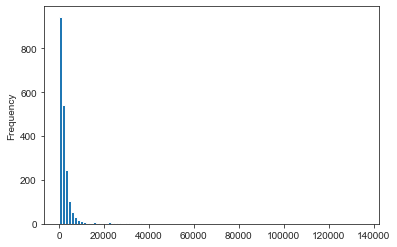

In [12]:
labelled_data["text"].apply(len).plot(kind="hist", bins=100)

### Load unlabelled data

We can now use the same procedure as above to load a dataset with "unlabelled" data. In our case this means that the dataset contains website data without the "software" label, so we don't know whether the companies are software firms or not...but we will know soon using machine learning magic 🧙!

The ```shape``` method tells us that we have 937 observations and three columns (compared to the labelled dataset, we are missing the "software" column).

In [13]:
unlabelled_data = pd.read_csv("../data/unlabelled_data.txt", sep="\t", encoding="utf-8", error_bad_lines=False)
print(unlabelled_data.shape)
unlabelled_data.head(5)

(937, 3)


,ID,url,text
0,0,http://wimatec-mattes.de,Dieses Motto begleitet uns täglich bei der Arb...
1,1,https://www.jacobi.net/,Reactivated carbons for water and vapour treat...
2,2,https://www.basf.com/de.html,Cookies helfen uns bei der Bereitstellung unse...
3,3,http://gjb.de,Diese Seite verwendet Frames. Frames werden vo...
4,4,https://www.roda-swiss.de/,| Transparenz und Ihre Privatsphäre sind uns w...


In [16]:
unlabelled_data["text"].apply(len).describe()

count      937.000000
mean      2524.799360
std       4250.109905
min          1.000000
25%        711.000000
50%       1491.000000
75%       2732.000000
max      48516.000000
Name: text, dtype: float64

Not so much difference in terms of the mean between the two datasets.

In [17]:
labelled_data["text"].apply(len).mean() - unlabelled_data["text"].apply(len).mean()

34.014140341515485

## 5.2 Text preprocessing

### Excluding short texts

As we saw above, there are quite some websites with texts that are shorter than 500 characters and some even had only a single character. Let's exclude them because short or no text usually mean little or no information at all.

After that we have 1,649 observations left in our labelled dataset

In [18]:
print("Dataframe shape before: ", labelled_data.shape)
labelled_data = labelled_data[labelled_data["text"].apply(len) > 499]
print("Dataframe shape after: ", labelled_data.shape)

Dataframe shape before:  (2000, 4)
Dataframe shape after:  (1649, 4)


The same procedure should also be applied to the unlabelled dataset.

In [19]:
print("Dataframe shape before: ", unlabelled_data.shape)
unlabelled_data = unlabelled_data[unlabelled_data["text"].apply(len) > 499]
print("Dataframe shape after: ", unlabelled_data.shape)

Dataframe shape before:  (937, 3)
Dataframe shape after:  (772, 3)


### Standardising text

Right now, the texts in our dataset are exactly as they were downloaded from the company websites.

Let's have a look at an example by displaying observation with ```ID == 1928```. We also alter a pandas option to display us more of the texts.

In [20]:
pd.set_option('display.max_colwidth', 1000)

labelled_data[labelled_data["ID"] == 1928]

,ID,url,text,software
1928,1928,http://www.brandt-transporte.com/,| My Cart Copyright © 2018 . Powered byNew Products For October Monthly Specials For OctoberCategories Shop by Category Customer Services Quick Links Social MediaAMI Alexandre Mattiussi Amiri ANYA HINDMARCH Belstaff Diemme Issey Miyake Scott Tods Topo athletic Zone3 $124.52 $62.26 Save: 50% off $145.92 $72.96 Save: 50% off $125.17 $62.59 Save: 50% off $149.18 $74.59 Save: 50% off $145.29 $72.64 Save: 50% off $145.29 $72.64 Save: 50% off $526.69 $140.60 Save: 73% off $526.69 $140.60 Save: 73% off $592.66 $151.41 Save: 74% off $526.69 $140.60 Save: 73% off $526.69 $140.60 Save: 73% off $526.69 $140.60 Save: 73% off,0


As we can see, there can be quiet a lot of special characters (e.g. "%" or "€") and numbers in the text which we may want to exclude from our further analysis. We also may want to standardise all characters to lowercase, such that "Software" and "software" are recognized as the same words by the computer.

**Note** however that this is just one of many ways to preprocess your texts. Most modern Natural Language Processing (NLP) pipelines do not preprocess at all.

We will import a Python's *regular expression* package and apply the ```sub("FILTER", "REPLACE_STRING")``` function to the text column of our labelled dataset. We submit the ```sub()``` function with a so-called regular expression telling Python to delete all characters in the text that are not part of this list of characters:

```"abcdefghijklmnopqrstuvwxyzäöüß&. "```

The method ```lower()``` will cast all characters to lowercase, while ```strip()``` will delete "trailing" whitespaces (e.g. ```"end of sentence    "``` will become ```"end of sentence"```).

We will replace the original text in the "text" column with the result of this operation.

In [21]:
import re

labelled_data["text"] = labelled_data["text"].apply(lambda x: re.sub("[^abcdefghijklmnopqrstuvwxyzäöüß& ']", "", str(x).lower()).strip())

Let's see how this step changed the text of our example above:

In [22]:
labelled_data[labelled_data["ID"] == 1928]

,ID,url,text,software
1928,1928,http://www.brandt-transporte.com/,my cart copyright powered bynew products for october monthly specials for octobercategories shop by category customer services quick links social mediaami alexandre mattiussi amiri anya hindmarch belstaff diemme issey miyake scott tods topo athletic zone save off save off save off save off save off save off save off save off save off save off save off save off,0


Looks good! Let's apply the same operation on the text column of the unlabelled dataset.

In [23]:
unlabelled_data["text"] = unlabelled_data["text"].apply(lambda x: re.sub("[^abcdefghijklmnopqrstuvwxyzäöüß& ']", "", str(x).lower()).strip())

In [24]:
unlabelled_data.head(4)

,ID,url,text
0,0,http://wimatec-mattes.de,dieses motto begleitet uns täglich bei der arbeit und ist uns gleichzeitig ansporn wir sind spezialisiert auf die herstellung von hochverschleißfesten messern für erntemaschinen und mehr als erstausrüster haben wir uns seit unserer gründung als partner der landmaschinenindustrie einen namen gemacht und wir können mehr unser portfolio umfasst das fertigen von schweißteilen kunden schätzen an uns qualität zuverlässigkeit service sowie schnelle verfügbarkeit diese garantieren wir mit unserem stets gut gefüllten lager und bieten damit kunden vor allem in saisonalen hochzeiten sicherheit wimatec mattes gmbh erhält fördermittel der eu und des landes badenwürttemberg nur unternehmen aus ganz badenwürttemberg schafften das qualifikationsauswahlverfahren der siebten auswahlrunde für das förderprogramm spitze auf dem land technologieführer für badenwürttemberg die wimatec mattes gmbh hat es in diese top geschafft voraussetzung für die erfolgreiche geschäftstätigkeit auf grundlage unserer ...
1,1,https://www.jacobi.net/,reactivated carbons for water and vapour treatment control of odours and contaminants from waste air streams as well as purification of process gases to remove unwanted impurities wastewater treatment control of vapour phase emissions and process chemical applications in petrochemical facilities treatment of flue gas emissions from waste incinerators power plants and other sources for mercury and dioxin control decolorisation and impurity removal from various process food streams chemical refining duties activated carbons used for precious metals recovery specialty activated carbons for industrial and military grade respirators as well as collective protection devices purification of pharmaceutical compounds and medicinal applications including ingestible carbons point of use pou and point of entry poe water treatment devices activated carbon is a processed natural material that is high in carbon content for example coal wood or coconut are perfect raw materials for this the result...
2,2,https://www.basf.com/de.html,cookies helfen uns bei der bereitstellung unserer dienste durch die nutzung unserer dienste erklären sie sich damit einverstanden dass wir cookies setzen hello you are logged in with access to additional information please login with your username and password you want to purchase products or view order status from basf se would you like to register to get personalized information to get additional information like specific downloads you want to purchase products or view order status from basf se please provide your registered email id to reset your password unser portfolio reicht von chemikalien kunststoffen und veredlungsprodukten bis hin zu pflanzenschutzmitteln feinchemikalien sowie öl und gas mit sechs verbundstandorten und weiteren produktionsstandorten unterstützt die basf kunden und partner in mehr als ländern weltweit oktober besuchen sie unsere webseite mit informationen rund um die basfaktie sowie einem überblick der basfgruppe erfahren sie mehr über den basfpalmdia...
4,4,https://www.roda-swiss.de/,transparenz und ihre privatsphäre sind uns wichtig warum cookies einfach weil sie helfen die website nutzbar zu machen ihre browsererfahrung zu verbessern und um mit social media zu interagieren klicken sie auf akzeptieren und fortfahren um die cookies zu akzeptieren und mit der seitennutzung fortzufahren datenschutzerklärung wir freuen uns sehr über ihr interesse an unserem unternehmen datenschutz hat einen besonders hohen stellenwert für die geschäftsleitung der rodaswiss kunststofftechnik gmbh eine nutzung der internetseiten der rodaswiss kunststofftechnik gmbh ist grundsätzlich ohne jede angabe personenbezogener daten möglich sofern eine betroffene person besondere services unseres unternehmens über unsere internetseite in anspruch nehmen möchte könnte jedoch eine verarbeitung personenbezogener daten erforderlich werden ist die verarbeitung personenbezogener

## 5.3 Text vectorization

The machine learning algorithms we will use require us to give numerical data to them. Raw text data as an input will not work! This means that we have to transfer our texts to some kind of numerical representation without loosing too much information. Transferring a text from a sequence of characters to a vector of numbers is called *text vectorization*.

<img src="../misc/text_vectorization.png" width="600">

There are many different ways to vectorize texts, from fancy techniques like [word embeddings](!https://en.wikipedia.org/wiki/Word_embedding) and topic models like [latent dirichlet allocation (LDA)](!https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to simple [word count models](!https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

### TFIDF vectorization

Today we will keep it rather simple and use an approach called **TFIDF** ([term frequency–inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) which basically counts how many times a word appears in a document and then reweights this count by the word's frequency over all known documents. The latter results in a decreased weight for common terms like "the", "and", "house" etc.
- **term frequency (TF)**: The number of times a term $t$ (word) appears in a document $d$ adjusted by the length of the document (number of all words $t'$ in document $d$).

\begin{equation*}
TF(t, d) =   \frac{f_t,_d}{\sum{f_{t^\prime},_d}}
\end{equation*}

- **inverse document frequency (IDF)**: Counts the number of documents $n_t$ an individual term $t$ appears over all documents $N$.
\begin{equation*}
IDF(t) =   log{\frac{N}{1 + n_t}}
\end{equation*}

- **term frequency-inverse document frequency (TFIDF)**: This step weights down common words like "the" and gives more weight to rare words like "software".

\begin{equation*}
TFIDF(t, d) = TF(t, d) * IDF(t)
\end{equation*}

We will use scikit-learn's [TFIDF Vectorizer](!https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to generate TFIDF vectors from our texts. Scikit-learn is the most popular machine learning package for Python and includes all kinds of ML algorithms from clustering to classification.

In [25]:
display(IFrame("https://scikit-learn.org/stable/", width=1200, height=500))

Scikit-learn (sklearn) should comes pre-installed with Anaconda. Otherwise you would install it using pip:

```pip install -U scikit-learn```

### Generating TFIDF vectors from text

Let's import sklearn's ```TfidfVectorizer``` function.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

First, we have to initialize a TFIDF vectorizer. We pass the ```analyzer="word"``` parameter to tell the function to analyze our texts at the level of words (rather than single characters, for example).

In [27]:
vectorizer = TfidfVectorizer(analyzer='word')

We now have to teach our vocabulary to the vectorizer. For that we can use the vectorizer's ```fit()``` method on our texts. In this step, the vectorizer also calculates the inverse document frequencies.

In [28]:
fitted_vectorizer = vectorizer.fit(labelled_data["text"])

We can now use the fitted vectorizer's ```transform()``` method to transform any text document to a TFIDF vector.

Let's transform the sentence ```"dies ist ein Test"``` and output the resulting vector using Python's ```print()``` function.

In [29]:
example_tfidf = fitted_vectorizer.transform(["dies ist ein test"])
print(example_tfidf)

  (0, 64619)	0.7674788380733668
  (0, 34005)	0.22768716559203767
  (0, 16620)	0.2383998438323033
  (0, 14515)	0.5498184265691286


The output you see is a so-called *sparse matrix*. In a sparse matrix, only non-zero elements are memorized and mapped using indexes. This actually saves A LOT of memory. In the example above, there are only four non-zero elements in the matrix and their coordinates/indexes are given in the left parantheses. The elements on the right hand side give you the corresponding TFIDF value for the word mapped by the coordinates.

Let's have a look at the vocabulary that the vectorizer learned from our data. We call the ```vocabulary_``` method on the fitted vectorizer to retrieve then full vocabulary and the use a ```for``` loop to print the first items in the vocabulary:

In [30]:
vocabulary = fitted_vectorizer.vocabulary_

#little loop to print the first items in the vocabulary
for count, item in enumerate(iter(vocabulary.items())):
    print(item)
    if count >= 10:
        break

('das', 13209)
('ingenieurbüro', 32913)
('ibos', 31714)
('gmbh', 27194)
('wurde', 74328)
('am', 1890)
('in', 32182)
('görlitz', 28454)
('gegründet', 24982)
('unser', 67469)
('handlungsschwerpunkt', 28901)


We can also get the vocabulary index of a word directly (this only works for words that were learned during the ```fit()``` and thus are in the vocabulary):

In [24]:
vocabulary["test"]

64619

In [31]:
vocabulary["istari"]

KeyError: 'istari'

But how many words are in our vocabulary, actually? We can see that by calculating its length using Python's ```len()``` function:

In [32]:
len(vocabulary)

76713

Those are quiet a lot of words. It may be a good idea to shrink down our vocabulary a bit, especially because this will reduce both memory consumption and the required computational power when we start doing ML magic!

A common approach to do so is to apply so-called *popularity-based filtering*. Hereby, we exclude very common and/or extremly uncommon words from our vocabulary. This can be achieved by passing the corresponding parameters to the vectorizer during fitting. 

Let's overwrite our vectorizer and create a new one which includes only those words that appear in a maximum (```max_df```) of 80% and a minimum (```min_df```) of 1% of the websites. 

In [33]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=0.01, max_df=0.8)
fitted_vectorizer = vectorizer.fit(labelled_data["text"])
vocabulary = fitted_vectorizer.vocabulary_

The vocabulary should be way smaller now:

In [34]:
len(vocabulary)

2622

This should have excluded super frequent words like "der".

In [35]:
vocabulary["der"]

KeyError: 'der'

Medium common words like "test", should be still included.

In [36]:
vocabulary["test"]

2151

## 5.4 Train and test sets

We will now split our labelled dataset into a **training set** and a **test set**. The training set will be used to train our machine learning model to predict the correct labels (classes). After the training, we will use the trained model to predict the labels of all the observations in the test set, which was not used for training. Based on the prediction performance in the test set, we can evaluate the prediction performance of our trained model.

This two-step approach is used to make sure that the ML model does not simply memorize all the observations in the training data, but instead derives universal rules on how to distinguish the different classes. This universal ability is called **generalization** and is very desireable in machine learning. In contrast, the over-memorization of the training set and a model's resulting bad performance using other data is called **overfitting**.

<img src="../misc/training_split.png" width="500">

The **training** of a machine learning model describes the process of teaching the model how to achive a certain learning task. In the case of a classification tasks, we give the model a list of properties $X$ (**features** or **attributes**) that are used to calculate a predicted outcome (**label** or **class**) $\hat{Y}$. We then compare the predicted outcome $\hat{Y}$ to the true outcome $Y$ that we know because we have a labelled dataset. In our example, we will use the trained ML model to predict whether a text comes from a software company website ($\hat{Y}$ = 1 or 0) and the compare our predictions against the true values of $Y$. 

The difference between the predicted and the true outcome is then used to calculate an **error**. We then start to **optimize** (**train**) the model by adjusting its internal numbers $W$ (**weights**) to minimize the error.

<img src="../misc/training.png" width="500">

This type of training is called **supervised learning** because we supervise the training outcome and assess each output predicted label of the model.

In our case, the features (attributes) of our observations are the texts as TFIDF vectors and our labels are the "1" and "0" classes in the "software" column. In another ML task, the attributes could be, for example, the properties/features of a house (location, size, number of rooms etc.) and the outcome we want to predict could be the house's selling price.

So let's first shuffle our data (always do that to make sure there is no systematic order in your data) and then create a list with our features $X$ and a list with the corresponding labels $Y$. For the features we select the text column from our labelled dataset and transform them to TFIDF vectors using our trained vactorizer. 

In [38]:
labelled_data = labelled_data.sample(frac=1.0, random_state=12) # a fixed random_state ensures that the shuffle will result in the same order every time
features = fitted_vectorizer.transform(labelled_data["text"])
labels = labelled_data["software"]

Remeber that we hat 1,649 observations in our labelled dataset. 

In [39]:
labelled_data.shape

(1649, 4)

Let's take the first 1,250 observations for the training set. The remaining obseravtions will be assigned to the test set and put aside for the moment.

In [41]:
features_trainset = features[:1250]
labels_trainset = labels[:1250]

features_testset = features[1250:]
labels_testset = labels[1250:]

*Note: In a real life ML task, you should train your tfidf vectorizer on the training dataset only and not the test set.*

## 5.5 Training a logit regression classifier

Let's train our first model. We will start with something basic: A [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression). This classifier is a pretty popular model for binary outcome variables. Again, we will use scikit-learn for this task.

In [42]:
from sklearn.linear_model import LogisticRegression

First, we have to initialize the logisitic regression model. We pass it the parameter ```class_weight="balanced"``` because we have a pretty unbalanced dataset (one class in way more frequent than the other). The ```"balanced"``` parameter will make sure that the model will pay more attention to the infrequent class (in our case the "software"  ```1``` class).

In [43]:
logit_classifier = LogisticRegression(class_weight="balanced")

We can now train the classifier using its ```fit()``` method and passing the features and corresponding labels of our training set.

In [44]:
trained_logit_classifier = logit_classifier.fit(features_trainset, labels_trainset)

You just trained your first machine learning model! But how good is it at distinguishing the web texts of software firms from other firm types? 

Let's test that with an example sentence that we transfer to a TFIDF vector using our trained vectorizer:

In [45]:
bauernhof_tfidf = fitted_vectorizer.transform(["das ist ein bauernhof und wir bauen getreide an"])

In [46]:
print(bauernhof_tfidf)

  (0, 1208)	0.279137030214422
  (0, 564)	0.2922704239296758
  (0, 441)	0.2944505058129105
  (0, 206)	0.8119552312781735
  (0, 55)	0.30114468231328534


We can now pass this TFIDF vector to our trained logit classifier and tell it to predict its label using the ```predict()``` method:

In [47]:
trained_logit_classifier.predict(bauernhof_tfidf)

array([0], dtype=int64)

The predicted label is ```0``` (aka "not a software company"). Awesome 🥳🥳🥳!

We can also check out the probability for both classes by using the ```predict_proba()``` method:

In [48]:
trained_logit_classifier.predict_proba(bauernhof_tfidf)

array([[0.67518489, 0.32481511]])

The first number above gives you the probability that the label is "0" while the second number is the probability that the label is ```1```. So the classifier is not too confident (about 60-65%) that the text comes from the website of a non-software company (**WARNING: Your results may differ!**).

Let's try one more example:

In [49]:
programmer_tfidf = fitted_vectorizer.transform(["wir programmieren software"])
trained_logit_classifier.predict_proba(programmer_tfidf)

array([[0.03145259, 0.96854741]])

In [50]:
trained_logit_classifier.predict(programmer_tfidf)

array([1], dtype=int64)

Wow! In this example, the model is absolutely sure (97%) that the text comes from a sofware company.

We should now test our trained classifier using the test set which we put aside:

In [51]:
predicted_labels = trained_logit_classifier.predict(features_testset)

We can now ```print()``` the predicted labels...

In [52]:
print(predicted_labels)

[0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0]


...and the true labels...

In [53]:
print(labels_testset.values)

[0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0]


...and compare them one by one.

In [54]:
print(predicted_labels == labels_testset.values)

[ True  True False  True False  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True False  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True False  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True Fa

Wow...at first glace that looks pretty convincing. It seems like most of the predicted labels match their true counterparts, but not all of them.

Let's quantify the classifier's prediction performance by generating a scikit-learn **classification report**. The report contains several measures that allow us to evaluate the performance of our trained model in the test set:

- **precision**: the fraction of observations that were predicted to have label $\hat{y} = 1$ and that actually have the true label $y = 1$ and vice versa.
- **recall**: the fraction of observations that have the true label $y = 1$ and that were predicted to have $\hat{y} = 1$ and vice versa.
- **f1-score**: a composite measure that combines both precision and recall.
- **support**: simply the number of observations with this true label in the test set.

<img src="../misc/classification_report.png" width="200">

In [55]:
from sklearn.metrics import classification_report

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       323
           1       0.71      0.79      0.75        76

    accuracy                           0.90       399
   macro avg       0.83      0.86      0.84       399
weighted avg       0.90      0.90      0.90       399



Not too bad! As you can see, the classification report gives you precision, recall, f1-score, and support for both labels (```1``` and ```0```). We could summarize the report as follows:
- 95% of the observations that were labeled ```0``` by the classifier actually have the true label ```0```. For label ```1``` this value is only 71%
- 92% of the observations that have the true label ```0``` were also predicted to have have the label ```0``` by the classifier. For label ```1``` this value is only 75%.

So if our goal was to identify most of the software firms in the unlabelled dataset (**true positives**) while limiting the number of non-software firms that are wrongly classified as software firm (**false positives**), we could say:

*7 out of 10 firms that were predicted to be software firms are actually software firms and we are able to recover 8 of 10 software firms in the dataset.*

As a final step, we can create a new column with our predicted labels in our labelled dataset...

In [56]:
labelled_data.loc[labelled_data.index[1250:], 'prediction'] = predicted_labels

...and have a look at a random observations that has been assigned the wrong class. 

In [57]:
wrong_prediction = labelled_data[(labelled_data["software"] != labelled_data["prediction"]) & (labelled_data["prediction"].notnull())].sample(1)
wrong_prediction

,ID,url,text,software,prediction
1365,1365,https://www.ave-online.de/,der wichtigste wettbewerbsfaktor auf dem energiemarkt ist die zufriedenheit der energiekunden allerdings kommt kundenzufriedenheit selten von liebe auf den ersten blick deshalb handeln wir für sie an allen kontaktpunkten zwischen ihnen und ihren kunden und füllen diese mit positiven kundenerlebnissen in der kundenbeziehungspflege kommt es wie in jeder guten beziehung selten auf einzelmaßnahmen an was nützt ein bunter blumenstrauß wenn es an empathie gespür und am richtigen umgangston für den umworbenen mangelt wenig deshalb entwickeln wir gemeinsam mit ihnen eine ganzheitliche kundenservicestrategie die ihre kunden lieben werden kundenerfahrungsmanagement das gute gefühl ihrer kunden liegt uns sehr am herzen deshalb haben wir den anspruch für unternehmen des energiemarkts passgenaue dienstleistungen anzubieten mit rund mitarbeitern erbringen wir für über kunden aller sparten marktrollen und strukturen individuelle prozessdienstleistungen entlang der costumer journey und zwar ...,0,1.0


In [58]:
display(IFrame(wrong_prediction["url"].values[0], width=1200, height=350))

In a final step, we create a new column "software" in our unlabelled dataset and predict the labels using our trained logit classifier.

In [59]:
unlabelled_data["predicted_software"] = unlabelled_data["text"].apply(lambda text: trained_logit_classifier.predict(fitted_vectorizer.transform([text]))[0])
unlabelled_data.head(3)

,ID,url,text,predicted_software
0,0,http://wimatec-mattes.de,dieses motto begleitet uns täglich bei der arbeit und ist uns gleichzeitig ansporn wir sind spezialisiert auf die herstellung von hochverschleißfesten messern für erntemaschinen und mehr als erstausrüster haben wir uns seit unserer gründung als partner der landmaschinenindustrie einen namen gemacht und wir können mehr unser portfolio umfasst das fertigen von schweißteilen kunden schätzen an uns qualität zuverlässigkeit service sowie schnelle verfügbarkeit diese garantieren wir mit unserem stets gut gefüllten lager und bieten damit kunden vor allem in saisonalen hochzeiten sicherheit wimatec mattes gmbh erhält fördermittel der eu und des landes badenwürttemberg nur unternehmen aus ganz badenwürttemberg schafften das qualifikationsauswahlverfahren der siebten auswahlrunde für das förderprogramm spitze auf dem land technologieführer für badenwürttemberg die wimatec mattes gmbh hat es in diese top geschafft voraussetzung für die erfolgreiche geschäftstätigkeit auf grundlage unserer ...,0
1,1,https://www.jacobi.net/,reactivated carbons for water and vapour treatment control of odours and contaminants from waste air streams as well as purification of process gases to remove unwanted impurities wastewater treatment control of vapour phase emissions and process chemical applications in petrochemical facilities treatment of flue gas emissions from waste incinerators power plants and other sources for mercury and dioxin control decolorisation and impurity removal from various process food streams chemical refining duties activated carbons used for precious metals recovery specialty activated carbons for industrial and military grade respirators as well as collective protection devices purification of pharmaceutical compounds and medicinal applications including ingestible carbons point of use pou and point of entry poe water treatment devices activated carbon is a processed natural material that is high in carbon content for example coal wood or coconut are perfect raw materials for this the result...,0
2,2,https://www.basf.com/de.html,cookies helfen uns bei der bereitstellung unserer dienste durch die nutzung unserer dienste erklären sie sich damit einverstanden dass wir cookies setzen hello you are logged in with access to additional information please login with your username and password you want to purchase products or view order status from basf se would you like to register to get personalized information to get additional information like specific downloads you want to purchase products or view order status from basf se please provide your registered email id to reset your password unser portfolio reicht von chemikalien kunststoffen und veredlungsprodukten bis hin zu pflanzenschutzmitteln feinchemikalien sowie öl und gas mit sechs verbundstandorten und weiteren produktionsstandorten unterstützt die basf kunden und partner in mehr als ländern weltweit oktober besuchen sie unsere webseite mit informationen rund um die basfaktie sowie einem überblick der basfgruppe erfahren sie mehr über den basfpalmdia...,0


Our ML model found about 125 software firms in our unlabelled dataset. 

In [61]:
unlabelled_data["predicted_software"].value_counts()

0    647
1    125
Name: predicted_software, dtype: int64

In [62]:
unlabelled_data.sample(1)

,ID,url,text,predicted_software
709,709,https://www.rathgeber-gmbh.de/,rathgeber gmbh industriestraße mittenaar tel fax rathgeber magyarorszg kft bernyi t h szkesfehrvrkontaktieren sie unsmittenaarhessen szkesfehrvrungarnthermostate und regler rathgeber regler für feste brennstoffe kapillarrohr thermostate sonstige anwendungen sie heizen wir regelnkonstruktion entwicklung produktion produktionhome aktuelles karriere produkte regler für feste brennstoffe kapillarrohrthermostate sonstige anwedungen zubehör über uns auslandsvertretungen kontakt einzelheiten einzelheiten einzelheiten rathgeber ihr leistungsfähiger partner wenn es um thermostatische regelungen sowohl bei elektrischen anlagen als auch bei feuerungsstätten geht mit einem team von engagierten und qualifizierten mitarbeitern fertigen wir in eigenen produktionsstätten regler für feste brennstoffe kapillarrohrthermostate entladeregler sowie umfangreiches zubehör für ihre planung steht ihnen unser team und unsere technik zur verfügung nutzen sie unser angebot und beschreiben sie u...,0


# 5.6 Calculating text similarities

Representing texts as vectors has another advantage: It allows us to easily calculate distances between pairs of texts. By calculating such pairwise distances, we are able to identify pairs of texts that are very similar (close) or dissimilar (distant) to each other. Calculating the distances between observations in our dataset can be understood as comparing the business activities of the companies as they are described on their websites. 

Let's try this out and see whether we can find Geographic Information System (GIS) software companies in our unlabelled dataset!

First, we want to retrain our TFIDF vectorizer on our unlabelled dataset without the popularity-based filtering. This makes sure that all the words (about 42,000) in the unlabelled dataset are included in the resulting vocabulary.

In [64]:
vectorizer = TfidfVectorizer(analyzer='word')
trained_vectorizer = vectorizer.fit(unlabelled_data["text"])
vocabulary = vectorizer.vocabulary_
len(vocabulary)

42336

Next, we create a single TFIDF vector from a description of the company type we are looking for.

In [65]:
search_tfidf = trained_vectorizer.transform(["gis geographie geographische informationssysteme geodaten"])

Let's create another TFIDF with AI keywords too.

In [73]:
search_tfidf_2 = trained_vectorizer.transform(["künstliche intelligenz artificial intelligence ai ki machine learning maschinelles lernen"])

In [68]:
print(search_tfidf)

  (0, 17874)	0.5365635470684603
  (0, 14829)	0.5532618101527164
  (0, 14052)	0.637182022175651


We will use the popular [**cosine similarity**](!https://www.machinelearningplus.com/nlp/cosine-similarity/) to calculate the similarity between our TFIDF vectors. Cosine similarity measures the similarity between vectors based on their orientation in the high-dimensional vector space they live in. The smaller the angle between two documents, the more similar they are.

Again, we will use a function from scikit-learn [```cosine_similarity()```](!https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to calculate the cosine similarity between our search TFIDF vectors and the TFIDF vectors representing the company website texts in our unlabelled dataset. We do so by applying the function to the text column and creating a new column "similarity" with the output.

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

unlabelled_data["similarity_gis"] = unlabelled_data["text"].apply(lambda x: cosine_similarity(search_tfidf, trained_vectorizer.transform([x])).tolist()[0][0])

unlabelled_data["similarity_ai"] = unlabelled_data["text"].apply(lambda x: cosine_similarity(search_tfidf_2, trained_vectorizer.transform([x])).tolist()[0][0])

Let's have a look at those software firms that are most similar to our search vector. We can do that by restricting our dataframe to software firms and sorting it (```sort_values()```) by our new "similarity" columns. 

In [80]:
top_hit = unlabelled_data[unlabelled_data["predicted_software"] == 1].sort_values(by=["similarity_gis"], ascending=False).head(1)
top_hit

,ID,url,text,predicted_software,similarity_gis,similarity_ai
179,179,http://srp-gmbh.de,von der über die bis zur ob als einzelarbeitsplatz oder als dezentraler facharbeitsplatz am desktop tablet oder am handy unser system bietet komponenten für alle geräte die ogctechnology bietet für eine vielzahl von anwendungsfällen werkzeuge und funktionen für die erfassung pflege bereitstellung und präsentation von geo und sachdaten im intra und internet sowie mobil unterwegs die ogctechnology wurde auf der basis von open source technologien wie java gwt openlayers und geotools entwickelt und orientiert sich konsequent an standards wie saga wc ogc isotc bei der open gis component technology handelt es sich um eine komplettlösung für den aufbau von geodateninfrastrukturen von der herstellung komplexer fachdaten über die bereitstellung bis hin zur präsentation stellt die ogctechnology alle erforderlichen werkzeuge zur verfügung einmal installiert können eine vielzahl von anwendungsfällen mit den vorhanden werkzeugen ohne weitere programmierkenntnisse umgesetzt werden konfigurieren ...,1,0.050973,0.0


In [81]:
display(IFrame(top_hit["url"].values[0], width=1200, height=350))

In [77]:
top_hit_ai = unlabelled_data[unlabelled_data["predicted_software"] == 1].sort_values(by=["similarity_ai"], ascending=False).head(5)
top_hit_ai

,ID,url,text,predicted_software,similarity_gis,similarity_ai
249,249,https://www.cpu-24-7.com/,individual on demand hpcclustersolutions cae as a service scalable ready to use and secure individual on demand hpcclustersolutions cae as a service scalable ready to use and secure individual and standardized hpc cluster solutions for your computer aided engineering cae projects we support your digitization using cloud solutions for iot machine learning ai and big data cpu is the leading provider of cae as a service solutions and develops and operates unique on demand services for high performance computing hpc that are based on the latest globally accepted industry standards for hardware software and applications augustbebelstraße de potsdam msc software conference german lsdyna forum cpu gmbh cae enterprise cae express engineering cloud service providercae services digital engineering servicescaesolutions navigate company upcoming events contact supporttoggle navigation,1,0.0,0.081769
277,277,http://www.cst-gmbh.eu/company_de.html,die ist ein unternehmen im bereich der mit optischen mitteln das team der beschäftigt sich seit mit allem was zur zur effizienten diagnose und der analyse der gewonnenen daten gehört die firma hat ihren sitz in waldshuttiengen deutschland gerne beschäftigen wir uns mit ungewöhnlichen und anspruchsvollen aufgaben unsere software lösungen erarbeiten wir gemäß ihren anforderungen sowohl für linuxembedded als auch für windows partner referenzen impressum datenschutz leistungen unternehmen beratung entwicklung produkte team anfahrt karriere en de leistungen beratung entwicklung produkte unternehmen team anfahrt karriere referenzen partner datenschutz impressum en de kontaktieren sie uns jetztbeleuchtungen sensoren prozesse algorithmen machinevision neuronale netzwerke tensor flow industrie präventiver service monitoring elasticsearchdas unternehmenoptische inspektionen industrielle bildverarbeitung künstliche intelligenz internet der dingeunternehmen cst gmbh berührungslosen dia...,1,0.0,0.055849
376,376,https://www.mach.de/,am november begrüßen wir daniel günther ministerpräsident des landes schleswigholstein als eröffnungsredner auf unserem führungskräfteforum innovatives management erstmals nehmen neben verwaltungsmitarbeitern in leitenden funktionen auch führungskräfte aus wirtschaft und wissenschaft sowie vertreter der startupszene teil und ermöglichen durch ihre impulse neue spannende blicke weit über den verwaltungsalltag hinaus die neuregelung des b im umsatzsteuergesetz wirft viele fragen auf die nicht nur kirchenverwaltungen betreffen martin scholz mach fachexperte für finanzen schafft klarheit wir müssen bis zum auf die elektronische aktenführung umstellen lässt sich das nicht mit einem dieser neuen zentralen eaktendienste realisieren wird dieser dienst rechtzeitig in betrieb gehen und alle anforderungen abdecken mit welchem aufwand müssen wir bei der einführung rechnen hier finden sie die antworten blockchain künstliche intelligenz augmented reality was steht dahinter welche mehrwerte ...,1,0.0,0.045024
546,546,https://www.insiders-technologies.de/home.html,wie ovation die stimmung ihrer kunden erkennt wie ovation mit chatbots ihren kundenservice optimiert smart flow ist unser standardprodukt für innovatives omnikanal response management kommunizieren sie mühelos und in echtzeit mit ihren kunden smart capture ist unsere app für das ortsunabhängige erfassen und einreichen von dokumenten mit mobilen endgeräten exzellenter service durch kundenkommunikation über alle kanäle wir begleiten sie bei der digitalen transformation optimale geschäftsprozesse und exzellente kundenkommunikation wir sind der erfahrene und starke partner an ihrer seite optimieren sie ihre prozesse für die zukunft mit unserer expertise als langjähriger partner führender finanzdienstleister wir begleiten gesetzliche und öffentliche kassen in die digitale transformation vertrauen auch sie unserer expertise moderne kundenkommunikatio

In [78]:
display(IFrame(top_hit_ai["url"].values[0], width=1200, height=350))